In [255]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [256]:
# Create Tensors to hold input and outputs.

beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[11,12,13,14,15]


def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [257]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2283, dtype=torch.float64)

tensor(0.2145, dtype=torch.float64)

tensor(0.2181, dtype=torch.float64)

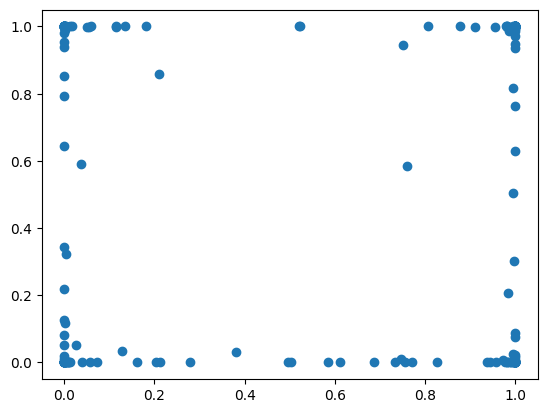

In [237]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

In [238]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [241]:
################## first step##################

#0.6,0.5
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
            
            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.005,0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=30)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_1d138_00000,TERMINATED,10.224.0.12:13567,0.01,0.002,1,26.3722,1.56813
train_model_1d138_00001,TERMINATED,10.224.0.12:13691,0.02,0.001,1,26.3747,1.63814
train_model_1d138_00002,TERMINATED,10.224.0.12:13694,0.005,0.001,1,26.2612,1.83851
train_model_1d138_00003,TERMINATED,10.224.0.12:13696,0.04,0.001,1,24.5776,1.48728
train_model_1d138_00004,TERMINATED,10.224.0.12:13699,0.05,0.001,1,26.3527,1.37019
train_model_1d138_00005,TERMINATED,10.224.0.12:13702,0.05,0.001,1,26.1014,1.37019
train_model_1d138_00006,TERMINATED,10.224.0.12:13700,0.005,0.001,1,25.8335,1.83851
train_model_1d138_00007,TERMINATED,10.224.0.12:13705,0.005,0.002,1,25.8272,1.68449
train_model_1d138_00008,TERMINATED,10.224.0.12:13707,0.02,0.001,1,26.1607,1.63814
train_model_1d138_00009,TERMINATED,10.224.0.12:13710,0.005,0.002,1,26.103,1.68449


Result for train_model_1d138_00000:
  date: 2022-10-12_19-08-20
  done: false
  experiment_id: 14b67ccbe1ea4ec785bec7291d606a0d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5681262016296387
  node_ip: 10.224.0.12
  pid: 13567
  time_since_restore: 26.372180700302124
  time_this_iter_s: 26.372180700302124
  time_total_s: 26.372180700302124
  timestamp: 1665572900
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d138_00000
  warmup_time: 0.003702402114868164
  
Result for train_model_1d138_00000:
  date: 2022-10-12_19-08-20
  done: true
  experiment_id: 14b67ccbe1ea4ec785bec7291d606a0d
  experiment_tag: 0_lambda1=0.0100,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5681262016296387
  node_ip: 10.224.0.12
  pid: 13567
  time_since_restore: 26.372180700302124
  time_this_iter_s: 26.372180700302124
  time_total_s: 26.372180700302124
  timestamp: 1665572900
  timesteps_since_restore: 

Result for train_model_1d138_00020:
  date: 2022-10-12_19-08-22
  done: false
  experiment_id: 1387ec6ff8924d308ada5199e028a94f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4476423740386963
  node_ip: 10.224.0.12
  pid: 13737
  time_since_restore: 25.039953231811523
  time_this_iter_s: 25.039953231811523
  time_total_s: 25.039953231811523
  timestamp: 1665572902
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d138_00020
  warmup_time: 0.004686594009399414
  
Result for train_model_1d138_00020:
  date: 2022-10-12_19-08-22
  done: true
  experiment_id: 1387ec6ff8924d308ada5199e028a94f
  experiment_tag: 20_lambda1=0.0300,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4476423740386963
  node_ip: 10.224.0.12
  pid: 13737
  time_since_restore: 25.039953231811523
  time_this_iter_s: 25.039953231811523
  time_total_s: 25.039953231811523
  timestamp: 1665572902
  timesteps_since_restore:

Result for train_model_1d138_00016:
  date: 2022-10-12_19-08-22
  done: false
  experiment_id: 9a268987be3c4fe0aa130c52282ec592
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8385124325752258
  node_ip: 10.224.0.12
  pid: 13729
  time_since_restore: 25.662466049194336
  time_this_iter_s: 25.662466049194336
  time_total_s: 25.662466049194336
  timestamp: 1665572902
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d138_00016
  warmup_time: 0.006722450256347656
  
Result for train_model_1d138_00017:
  date: 2022-10-12_19-08-22
  done: false
  experiment_id: 5c9e4f6550b0427b900ee34f11334ba4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3701890766620637
  node_ip: 10.224.0.12
  pid: 13731
  time_since_restore: 25.79579782485962
  time_this_iter_s: 25.79579782485962
  time_total_s: 25.79579782485962
  timestamp: 1665572902
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d138_00017
  

Result for train_model_1d138_00008:
  date: 2022-10-12_19-08-23
  done: false
  experiment_id: 8a570ca2f8794f04b771a94cb1f0f634
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.638135689496994
  node_ip: 10.224.0.12
  pid: 13707
  time_since_restore: 26.160733461380005
  time_this_iter_s: 26.160733461380005
  time_total_s: 26.160733461380005
  timestamp: 1665572903
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d138_00008
  warmup_time: 0.0051577091217041016
  
Result for train_model_1d138_00008:
  date: 2022-10-12_19-08-23
  done: true
  experiment_id: 8a570ca2f8794f04b771a94cb1f0f634
  experiment_tag: 8_lambda1=0.0200,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.638135689496994
  node_ip: 10.224.0.12
  pid: 13707
  time_since_restore: 26.160733461380005
  time_this_iter_s: 26.160733461380005
  time_total_s: 26.160733461380005
  timestamp: 1665572903
  timesteps_since_restore: 0

2022-10-12 19:08:24,133	INFO tune.py:758 -- Total run time: 32.58 seconds (32.36 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
1d138_00000          1.568126         26.372181  True            None   
1d138_00001          1.638136         26.374668  True            None   
1d138_00002          1.838512         26.261156  True            None   
1d138_00003          1.487281         24.577626  True            None   
1d138_00004          1.370189         26.352735  True            None   
1d138_00005          1.370189         26.101434  True            None   
1d138_00006          1.838512         25.833472  True            None   
1d138_00007          1.684492         25.827194  True            None   
1d138_00008          1.638136         26.160733  True            None   
1d138_00009          1.684492         26.103041  True            None   
1d138_00010          1.538488         25.880615  True            N

In [242]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.29667227268219


{'lambda1': 0.05, 'lambda2': 0.002}

In [243]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.8
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3


# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2372, grad_fn=<AddBackward0>)

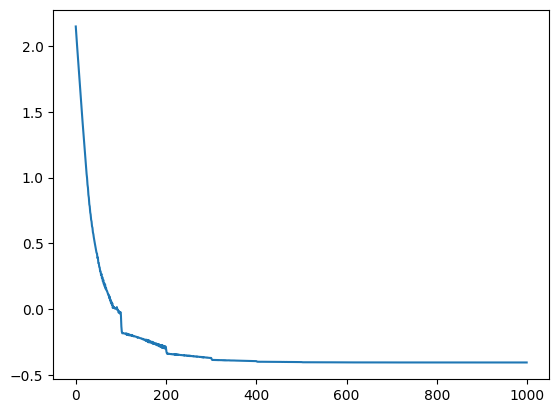

In [244]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [245]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(1.6842)

tensor(0.1125)

tensor(0.0112)

tensor(1.5606)

In [246]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[89,  1],
       [ 1, 69]])

array([[88,  0],
       [ 0, 72]])

array([[67,  2],
       [ 1, 90]])

In [247]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }

    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_49217_00000,TERMINATED,10.224.0.12:14693,0.75,0.04,0.003,1,30.4623,1.45333
train_model_49217_00001,TERMINATED,10.224.0.12:14953,0.25,0.04,0.001,1,30.9294,1.27525
train_model_49217_00002,TERMINATED,10.224.0.12:14955,0.45,0.04,0.001,1,30.9369,1.34398
train_model_49217_00003,TERMINATED,10.224.0.12:14957,0.09,0.04,0.002,1,30.3501,1.169
train_model_49217_00004,TERMINATED,10.224.0.12:14958,0.45,0.05,0.002,1,30.177,1.32542
train_model_49217_00005,TERMINATED,10.224.0.12:14960,0.65,0.04,0.002,1,28.8129,1.40652
train_model_49217_00006,TERMINATED,10.224.0.12:14962,0.75,0.05,0.003,1,30.3536,1.54048
train_model_49217_00007,TERMINATED,10.224.0.12:14964,0.06,0.04,0.002,1,32.3077,1.194
train_model_49217_00008,TERMINATED,10.224.0.12:14966,0.85,0.05,0.003,1,29.8483,1.53886
train_model_49217_00009,TERMINATED,10.224.0.12:14968,0.55,0.05,0.003,1,30.1017,1.47323


Result for train_model_49217_00000:
  date: 2022-10-12_19-09-38
  done: false
  experiment_id: a565952bda6a44afad182e3412f2bd4d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4533273100852966
  node_ip: 10.224.0.12
  pid: 14693
  time_since_restore: 30.462278604507446
  time_this_iter_s: 30.462278604507446
  time_total_s: 30.462278604507446
  timestamp: 1665572978
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00000'
  warmup_time: 0.003794431686401367
  
Result for train_model_49217_00000:
  date: 2022-10-12_19-09-38
  done: true
  experiment_id: a565952bda6a44afad182e3412f2bd4d
  experiment_tag: 0_eta=0.7500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4533273100852966
  node_ip: 10.224.0.12
  pid: 14693
  time_since_restore: 30.462278604507446
  time_this_iter_s: 30.462278604507446
  time_total_s: 30.462278604507446
  timestamp: 1665572978
  timesteps_si

Result for train_model_49217_00006:
  date: 2022-10-12_19-09-41
  done: false
  experiment_id: c574f86cf20945bd86e82d7e4fd97f11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5404805898666383
  node_ip: 10.224.0.12
  pid: 14962
  time_since_restore: 30.353641510009766
  time_this_iter_s: 30.353641510009766
  time_total_s: 30.353641510009766
  timestamp: 1665572981
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00006'
  warmup_time: 0.017824649810791016
  
Result for train_model_49217_00006:
  date: 2022-10-12_19-09-41
  done: true
  experiment_id: c574f86cf20945bd86e82d7e4fd97f11
  experiment_tag: 6_eta=0.7500,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5404805898666383
  node_ip: 10.224.0.12
  pid: 14962
  time_since_restore: 30.353641510009766
  time_this_iter_s: 30.353641510009766
  time_total_s: 30.353641510009766
  timestamp: 1665572981
  timesteps_si

Result for train_model_49217_00002:
  date: 2022-10-12_19-09-42
  done: false
  experiment_id: 28c4795474314b82af7131a58face283
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3439825177192688
  node_ip: 10.224.0.12
  pid: 14955
  time_since_restore: 30.93693232536316
  time_this_iter_s: 30.93693232536316
  time_total_s: 30.93693232536316
  timestamp: 1665572982
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00002'
  warmup_time: 0.0054471492767333984
  
Result for train_model_49217_00001:
  date: 2022-10-12_19-09-42
  done: false
  experiment_id: e4607e8bb68b4e9a82e72d2aac928d7b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2752541959285737
  node_ip: 10.224.0.12
  pid: 14953
  time_since_restore: 30.92937731742859
  time_this_iter_s: 30.92937731742859
  time_total_s: 30.92937731742859
  timestamp: 1665572982
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00001'


Result for train_model_49217_00007:
  date: 2022-10-12_19-09-43
  done: false
  experiment_id: c5e60d7f87e846e3a16825f73e27344a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1939986646175385
  node_ip: 10.224.0.12
  pid: 14964
  time_since_restore: 32.30774188041687
  time_this_iter_s: 32.30774188041687
  time_total_s: 32.30774188041687
  timestamp: 1665572983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00007'
  warmup_time: 0.007288932800292969
  
Result for train_model_49217_00007:
  date: 2022-10-12_19-09-43
  done: true
  experiment_id: c5e60d7f87e846e3a16825f73e27344a
  experiment_tag: 7_eta=0.0600,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1939986646175385
  node_ip: 10.224.0.12
  pid: 14964
  time_since_restore: 32.30774188041687
  time_this_iter_s: 32.30774188041687
  time_total_s: 32.30774188041687
  timestamp: 1665572983
  timesteps_since_re

Result for train_model_49217_00038:
  date: 2022-10-12_19-10-11
  done: false
  experiment_id: 719bc86c74d84148a76a6e4cd53ef85c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.194668972492218
  node_ip: 10.224.0.12
  pid: 14968
  time_since_restore: 30.20237421989441
  time_this_iter_s: 30.20237421989441
  time_total_s: 30.20237421989441
  timestamp: 1665573011
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00038'
  warmup_time: 0.009883403778076172
  
Result for train_model_49217_00038:
  date: 2022-10-12_19-10-11
  done: true
  experiment_id: 719bc86c74d84148a76a6e4cd53ef85c
  experiment_tag: 38_eta=0.1700,lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.194668972492218
  node_ip: 10.224.0.12
  pid: 14968
  time_since_restore: 30.20237421989441
  time_this_iter_s: 30.20237421989441
  time_total_s: 30.20237421989441
  timestamp: 1665573011
  timesteps_since_res

Result for train_model_49217_00037:
  date: 2022-10-12_19-10-12
  done: true
  experiment_id: 8e8f1c735a08481f883db70c2eca38f0
  experiment_tag: 37_eta=0.6500,lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4497673630714416
  node_ip: 10.224.0.12
  pid: 14995
  time_since_restore: 31.165313005447388
  time_this_iter_s: 31.165313005447388
  time_total_s: 31.165313005447388
  timestamp: 1665573012
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00037'
  warmup_time: 0.0040090084075927734
  
Result for train_model_49217_00040:
  date: 2022-10-12_19-10-12
  done: false
  experiment_id: adad8c379ba14004b1b2cb037424d8f3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2560874342918396
  node_ip: 10.224.0.12
  pid: 14993
  time_since_restore: 31.04825234413147
  time_this_iter_s: 31.04825234413147
  time_total_s: 31.04825234413147
  timestamp: 1665573012
  timesteps_sin

Result for train_model_49217_00051:
  date: 2022-10-12_19-10-13
  done: true
  experiment_id: d82da626bed74b778ec083d2742aaf61
  experiment_tag: 51_eta=0.0600,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0338705122470855
  node_ip: 10.224.0.12
  pid: 14974
  time_since_restore: 31.124595880508423
  time_this_iter_s: 31.124595880508423
  time_total_s: 31.124595880508423
  timestamp: 1665573013
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00051'
  warmup_time: 0.004975795745849609
  
Result for train_model_49217_00052:
  date: 2022-10-12_19-10-14
  done: false
  experiment_id: 28c4795474314b82af7131a58face283
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1939986646175385
  node_ip: 10.224.0.12
  pid: 14955
  time_since_restore: 31.64401936531067
  time_this_iter_s: 31.64401936531067
  time_total_s: 31.64401936531067
  timestamp: 1665573014
  timesteps_sinc

Result for train_model_49217_00067:
  date: 2022-10-12_19-10-41
  done: false
  experiment_id: 53011d75871841c09ce2c4e12cfd15f4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5514622449874877
  node_ip: 10.224.0.12
  pid: 14997
  time_since_restore: 29.832485914230347
  time_this_iter_s: 29.832485914230347
  time_total_s: 29.832485914230347
  timestamp: 1665573041
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00067'
  warmup_time: 0.005282878875732422
  
Result for train_model_49217_00067:
  date: 2022-10-12_19-10-41
  done: true
  experiment_id: 53011d75871841c09ce2c4e12cfd15f4
  experiment_tag: 67_eta=0.8500,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5514622449874877
  node_ip: 10.224.0.12
  pid: 14997
  time_since_restore: 29.832485914230347
  time_this_iter_s: 29.832485914230347
  time_total_s: 29.832485914230347
  timestamp: 1665573041
  timesteps_s

Result for train_model_49217_00082:
  date: 2022-10-12_19-10-42
  done: false
  experiment_id: adad8c379ba14004b1b2cb037424d8f3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2412104785442353
  node_ip: 10.224.0.12
  pid: 14993
  time_since_restore: 29.74242329597473
  time_this_iter_s: 29.74242329597473
  time_total_s: 29.74242329597473
  timestamp: 1665573042
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00082'
  warmup_time: 0.007407426834106445
  
Result for train_model_49217_00082:
  date: 2022-10-12_19-10-42
  done: true
  experiment_id: adad8c379ba14004b1b2cb037424d8f3
  experiment_tag: 82_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2412104785442353
  node_ip: 10.224.0.12
  pid: 14993
  time_since_restore: 29.74242329597473
  time_this_iter_s: 29.74242329597473
  time_total_s: 29.74242329597473
  timestamp: 1665573042
  timesteps_since_r

Result for train_model_49217_00070:
  date: 2022-10-12_19-10-42
  done: false
  experiment_id: 719bc86c74d84148a76a6e4cd53ef85c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6204870581626891
  node_ip: 10.224.0.12
  pid: 14968
  time_since_restore: 31.219324350357056
  time_this_iter_s: 31.219324350357056
  time_total_s: 31.219324350357056
  timestamp: 1665573042
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00070'
  warmup_time: 0.009883403778076172
  
Result for train_model_49217_00087:
  date: 2022-10-12_19-10-42
  done: true
  experiment_id: 3f04baec872f408f9e94aaa972e6cef7
  experiment_tag: 87_eta=0.8500,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5533989787101745
  node_ip: 10.224.0.12
  pid: 15003
  time_since_restore: 29.469165563583374
  time_this_iter_s: 29.469165563583374
  time_total_s: 29.469165563583374
  timestamp: 1665573042
  timesteps_s

Result for train_model_49217_00084:
  date: 2022-10-12_19-10-43
  done: false
  experiment_id: e4607e8bb68b4e9a82e72d2aac928d7b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2412104785442353
  node_ip: 10.224.0.12
  pid: 14953
  time_since_restore: 30.775876998901367
  time_this_iter_s: 30.775876998901367
  time_total_s: 30.775876998901367
  timestamp: 1665573043
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49217_00084'
  warmup_time: 0.00304412841796875
  
Result for train_model_49217_00084:
  date: 2022-10-12_19-10-43
  done: true
  experiment_id: e4607e8bb68b4e9a82e72d2aac928d7b
  experiment_tag: 84_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2412104785442353
  node_ip: 10.224.0.12
  pid: 14953
  time_since_restore: 30.775876998901367
  time_this_iter_s: 30.775876998901367
  time_total_s: 30.775876998901367
  timestamp: 1665573043
  timesteps_si

2022-10-12 19:10:45,533	INFO tune.py:758 -- Total run time: 100.07 seconds (99.83 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
49217_00000          1.453327         30.462279  True            None   
49217_00001          1.275254         30.929377  True            None   
49217_00002          1.343983         30.936932  True            None   
49217_00003          1.169000         30.350057  True            None   
49217_00004          1.325425         30.176992  True            None   
...                       ...               ...   ...             ...   
49217_00091          1.422039         30.917810  True            None   
49217_00092          1.193999         30.301398  True            None   
49217_00093          1.592152         29.216568  True            None   
49217_00094          1.100164         29.271651  True            None   
49217_00095          1.192032         28.635580  True            N

In [248]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.0338705122470855


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.06}

In [249]:
final_parameter

{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.06}

In [250]:
################## second step##################

#no prior
prior=[]

#0.4,0.4
# set hyperparamters
# final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.8
max_iteration=1000

inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
        #     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)

    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3270, grad_fn=<AddBackward0>)

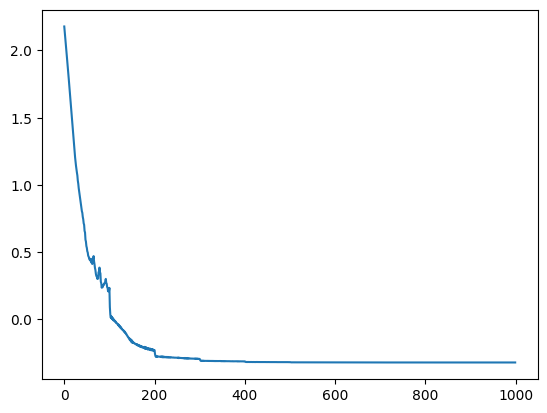

In [251]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [252]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2819e-01, -1.7024e-01, -2.3044e-01, -1.3165e-01, -2.0697e-01,
         -2.1833e-01, -1.5100e-01, -1.3960e-01, -1.8580e-01, -1.4871e-01,
          1.8535e-06,  1.6700e-07,  2.9289e-06,  2.1098e-03,  7.2474e-07,
          8.8510e-07, -3.2716e-06, -2.5783e-06,  2.5955e-06, -1.6092e-06,
          1.4999e-06,  3.0678e-06,  3.1088e-06, -9.6145e-07,  1.7399e-06,
          8.6918e-07, -2.9720e-06, -1.9525e-06, -1.0635e-07, -6.8984e-07,
         -3.6525e-07,  2.4524e-06,  1.3006e-06,  4.0947e-06, -2.2830e-06,
         -1.1790e-06,  8.5138e-07, -1.6149e-06,  1.4679e-06,  3.9503e-07,
         -5.0895e-07,  2.6212e-06, -1.3522e-06, -2.6208e-06,  3.4342e-06,
         -8.3006e-07, -2.8093e-06,  1.2862e-06, -3.0789e-06,  2.3784e-07,
         -3.2267e-06, -4.8005e-07, -9.6779e-07, -8.8570e-08, -3.0332e-06,
          4.1364e-06,  1.7822e-06,  2.2099e-06,  2.1064e-06,  8.4101e-07,
         -2.8687e-06, -5.5371e-07, -2.3810e-04,  3.6663e-07, -9.2532e-07,
          2.4694e-06, -3.1378e-07, -2.

tensor([[-1.2819e-01, -1.7024e-01, -2.3044e-01, -1.3165e-01, -2.0697e-01,
         -2.1833e-01, -1.5100e-01, -1.3960e-01, -1.8580e-01, -1.4871e-01,
          1.8535e-06,  1.6700e-07,  2.9289e-06,  2.1098e-03,  7.2474e-07,
          8.8510e-07, -3.2716e-06, -2.5783e-06,  2.5955e-06, -1.6092e-06,
          1.4999e-06,  3.0678e-06,  3.1088e-06, -9.6145e-07,  1.7399e-06,
          8.6918e-07, -2.9720e-06, -1.9525e-06, -1.0635e-07, -6.8984e-07,
         -3.6525e-07,  2.4524e-06,  1.3006e-06,  4.0947e-06, -2.2830e-06,
         -1.1790e-06,  8.5138e-07, -1.6149e-06,  1.4679e-06,  3.9503e-07,
         -5.0895e-07,  2.6212e-06, -1.3522e-06, -2.6208e-06,  3.4342e-06,
         -8.3006e-07, -2.8093e-06,  1.2862e-06, -3.0789e-06,  2.3784e-07,
         -3.2267e-06, -4.8005e-07, -9.6779e-07, -8.8570e-08, -3.0332e-06,
          4.1364e-06,  1.7822e-06,  2.2099e-06,  2.1064e-06,  8.4101e-07,
         -2.8687e-06, -5.5371e-07, -2.3810e-04,  3.6663e-07, -9.2532e-07,
          2.4694e-06, -3.1378e-07, -2.

tensor([[-1.6214e-01, -1.9703e-01, -2.5804e-01, -1.8476e-01,  1.9747e-01,
         -2.8488e-01, -1.7424e-01, -1.5647e-01, -1.9352e-01, -2.1030e-01,
         -7.1008e-07, -2.3296e-09,  1.1540e-07,  4.6854e-02, -1.9362e-08,
          5.4246e-07, -7.9728e-08,  8.1805e-08, -9.2881e-07, -3.2744e-08,
         -1.8787e-09, -2.8746e-07,  1.6217e-07, -4.5823e-07,  1.1955e-06,
         -2.4883e-09,  1.9660e-08, -7.2596e-07, -1.3297e-07,  2.3439e-08,
          1.0156e-07,  4.9306e-08,  1.8177e-07, -1.3555e-07,  3.1849e-07,
          1.7622e-07,  4.5253e-07,  3.0393e-08,  4.9754e-08, -4.3391e-07,
          1.8006e-07, -4.3073e-09, -3.2407e-07,  8.8787e-07, -4.6081e-10,
         -2.3912e-07, -1.0670e-07, -9.6102e-08, -2.7971e-08, -5.8172e-08,
          8.3295e-08, -3.2755e-07, -2.7913e-07,  1.3732e-07, -8.2053e-09,
          1.0561e-07,  1.0906e-06,  4.3868e-07,  1.3439e-07, -7.1740e-08,
          1.0129e-08,  2.4405e-06, -1.5318e-02, -3.6917e-07,  3.7820e-07,
         -1.1370e-07, -4.1429e-07,  2.

In [253]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.8247e-01, 9.8415e-01, 1.7291e-01, 6.3629e-01, 1.1459e-03, 9.8286e-01,
        9.3717e-01, 5.4259e-02, 9.7891e-01, 8.3086e-01, 1.1174e-05, 9.7883e-01,
        9.8843e-01, 1.2937e-02, 5.0125e-01, 9.6500e-01, 8.7991e-02, 9.2652e-01,
        1.4311e-02, 4.9086e-03, 3.0732e-03, 9.7345e-01, 9.5992e-01, 4.7708e-01,
        7.3023e-01, 2.4753e-01, 2.0175e-01, 1.9629e-02, 5.4079e-01, 3.2077e-01,
        1.6045e-01, 1.6916e-01, 1.1641e-03, 5.1138e-01, 1.3826e-01, 8.1115e-01,
        9.2861e-01, 9.4555e-01, 2.7663e-01, 6.3770e-04],
       grad_fn=<SqueezeBackward0>)

tensor([7.7984e-02, 9.9746e-01, 2.5272e-02, 9.1536e-01, 8.1287e-01, 9.9447e-01,
        9.8579e-01, 9.9229e-01, 7.7461e-03, 8.1696e-01, 5.9205e-01, 9.9230e-01,
        5.8843e-07, 9.9741e-01, 8.0322e-02, 3.9879e-03, 9.9764e-01, 9.8466e-01,
        2.6559e-02, 9.0104e-01, 1.6498e-01, 2.2299e-01, 2.0432e-03, 2.6986e-07,
        7.7012e-01, 1.2689e-03, 2.0353e-01, 6.0061e-03, 2.2327e-01, 7.9202e-01,
        8.7694e-01, 5.6316e-02, 3.8429e-06, 9.7285e-02, 9.1859e-01, 9.9908e-01,
        9.7399e-01, 2.5975e-03, 9.9312e-01, 7.7058e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.4991, 0.9648, 0.9528, 0.9576, 0.0186, 0.2108, 0.6545, 0.1833, 0.9547,
        0.9346, 0.9162, 0.0899, 0.9707, 0.4934, 0.9682, 0.1038, 0.9686, 0.9345,
        0.9399, 0.9687, 0.7235, 0.4624, 0.8907, 0.8589, 0.0973, 0.0156, 0.0109,
        0.9641, 0.5430, 0.9566, 0.7335, 0.0028, 0.8861, 0.9077, 0.0162, 0.0914,
        0.4445, 0.8375, 0.5108, 0.1326], grad_fn=<SqueezeBackward0>)

In [254]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[44,  7],
       [11, 58]])

0.8405797101449275

0.8627450980392157

0.85

0.8923076923076924

0.8656716417910447

(raylet) [2022-10-12 20:34:48,531 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1469734912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:34:58,539 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1469624320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:08,546 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1469509632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:18,553 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1469378560; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-12 20:39:58,739 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1461817344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:08,743 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1461592064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:18,747 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1460314112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:28,752 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1459920896; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-12 20:45:08,892 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1439637504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:18,898 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1439105024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:28,904 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1439002624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:38,911 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1438887936; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-12 20:50:19,102 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1435086848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:29,109 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1435004928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:39,116 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1434914816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:49,123 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1434832896; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-12 20:55:29,316 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1431199744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:55:39,323 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1431097344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:55:49,330 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1430994944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:55:59,337 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1430753280; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-12 21:00:39,572 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1427189760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:00:49,579 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1427091456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:00:59,586 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1426853888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:01:09,593 E 17027 17045] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-11_18-32-40_113541_16914 is over 95% full, available space: 1426776064; capacity: 29394726912. Object creation will fa

In [231]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 2, 20]])

0.9090909090909091

1.0

array([[11,  4],
       [ 8, 17]])

0.68

0.7333333333333333

array([[14,  4],
       [ 1, 21]])

0.9545454545454546

0.7777777777777778

In [176]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.1635924e-01, -1.7104402e-01, -2.2935003e-01, -1.2235836e-01,
        -2.4878199e-01, -2.1311572e-01, -1.5602733e-01, -1.3264908e-01,
        -2.3014668e-01, -1.9197538e-01,  1.2814868e-06, -1.6167833e-06,
         2.2695438e-06,  1.7454237e-02,  1.2267417e-06, -4.0137911e-07,
        -2.6260955e-06, -2.0605466e-06,  2.3458920e-06,  1.1068505e-07,
        -1.7410964e-07,  1.4887078e-06, -4.6454514e-07,  1.8237848e-06,
         1.2657674e-06,  5.1171901e-07, -1.3448719e-06, -1.4949973e-06,
        -1.6491746e-06, -1.7838958e-06,  2.3281054e-06, -2.4091269e-06,
        -3.5512858e-07,  1.7891829e-06,  1.5762769e-06, -6.0291558e-07,
         2.4590390e-06, -3.4661818e-07, -4.8797517e-07, -1.4559987e-06,
         2.3376510e-06,  1.9580687e-06,  1.7342139e-06, -6.1630971e-07,
         9.7190086e-03,  1.4615417e-06, -2.6536602e-06, -1.6670836e-06,
         5.3469972e-07, -5.6769309e-08, -2.6379221e-06, -6.5038165e-08,
        -1.9009956e-07, -1.6082779e-06, -2.0343596e-06,  1.18441

array([[-1.1635924e-01, -1.7104402e-01, -2.2935003e-01, -1.2235836e-01,
        -2.4878199e-01, -2.1311572e-01, -1.5602733e-01, -1.3264908e-01,
        -2.3014668e-01, -1.9197538e-01,  1.2814868e-06, -1.6167833e-06,
         2.2695438e-06,  1.7454237e-02,  1.2267417e-06, -4.0137911e-07,
        -2.6260955e-06, -2.0605466e-06,  2.3458920e-06,  1.1068505e-07,
        -1.7410964e-07,  1.4887078e-06, -4.6454514e-07,  1.8237848e-06,
         1.2657674e-06,  5.1171901e-07, -1.3448719e-06, -1.4949973e-06,
        -1.6491746e-06, -1.7838958e-06,  2.3281054e-06, -2.4091269e-06,
        -3.5512858e-07,  1.7891829e-06,  1.5762769e-06, -6.0291558e-07,
         2.4590390e-06, -3.4661818e-07, -4.8797517e-07, -1.4559987e-06,
         2.3376510e-06,  1.9580687e-06,  1.7342139e-06, -6.1630971e-07,
         9.7190086e-03,  1.4615417e-06, -2.6536602e-06, -1.6670836e-06,
         5.3469972e-07, -5.6769309e-08, -2.6379221e-06, -6.5038165e-08,
        -1.9009956e-07, -1.6082779e-06, -2.0343596e-06,  1.18441

array([[-1.1635924e-01, -1.7104402e-01, -2.2935003e-01, -1.2235836e-01,
        -2.4878199e-01, -2.1311572e-01, -1.5602733e-01, -1.3264908e-01,
        -2.3014668e-01, -1.9197538e-01,  1.2814868e-06, -1.6167833e-06,
         2.2695438e-06,  1.7454237e-02,  1.2267417e-06, -4.0137911e-07,
        -2.6260955e-06, -2.0605466e-06,  2.3458920e-06,  1.1068505e-07,
        -1.7410964e-07,  1.4887078e-06, -4.6454514e-07,  1.8237848e-06,
         1.2657674e-06,  5.1171901e-07, -1.3448719e-06, -1.4949973e-06,
        -1.6491746e-06, -1.7838958e-06,  2.3281054e-06, -2.4091269e-06,
        -3.5512858e-07,  1.7891829e-06,  1.5762769e-06, -6.0291558e-07,
         2.4590390e-06, -3.4661818e-07, -4.8797517e-07, -1.4559987e-06,
         2.3376510e-06,  1.9580687e-06,  1.7342139e-06, -6.1630971e-07,
         9.7190086e-03,  1.4615417e-06, -2.6536602e-06, -1.6670836e-06,
         5.3469972e-07, -5.6769309e-08, -2.6379221e-06, -6.5038165e-08,
        -1.9009956e-07, -1.6082779e-06, -2.0343596e-06,  1.18441

(raylet) [2022-10-05 13:12:23,691 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 143626240; capacity: 29394726912. Object creation will fail if spilling is required.


In [180]:
threshold=0.13
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.11635924, -0.17104402, -0.22935003, -0.12235836, -0.248782  ,
        -0.21311572, -0.15602733, -0.13264908, -0.23014668, -0.19197538,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 71])

11

(raylet) [2022-10-05 13:13:23,737 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 142852096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:13:33,745 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 142708736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:13:43,752 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 142581760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:13:53,760 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 142426112; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-05 13:18:33,969 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 124452864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:18:43,974 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 124170240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:18:53,979 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 123064320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:19:03,984 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 122662912; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-05 13:23:44,184 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 111689728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:23:54,191 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 111566848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:24:04,199 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 111411200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:24:14,207 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 111329280; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-05 13:28:54,401 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 107622400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:29:04,406 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 107450368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:29:14,412 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 107356160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:29:24,417 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 107204608; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-05 13:34:04,626 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 103473152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:34:14,634 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 103374848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:34:24,642 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 103206912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:34:34,649 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 103063552; capacity: 29394726912. Object creation will fail if spilling i

(raylet) [2022-10-05 13:39:14,860 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 98246656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:39:24,867 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 98103296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:39:34,874 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 97980416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:39:44,880 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 97812480; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-10-05 13:44:25,086 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 93941760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:44:35,095 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 93814784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:44:45,103 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 93704192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:44:55,109 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 93548544; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-10-05 13:49:35,315 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 88076288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:49:45,322 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 87924736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:49:55,328 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 87781376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:50:05,335 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 87531520; capacity: 29394726912. Object creation will fail if spilling is re

(raylet) [2022-10-05 13:54:45,605 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 80613376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:54:55,612 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 80445440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:55:05,620 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 80367616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-05 13:55:15,627 E 7008 7026] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-04_10-42-26_323558_6871 is over 95% full, available space: 80273408; capacity: 29394726912. Object creation will fail if spilling is re